# **Select your environment library**

In [ ]:
environment_library = 'gym'  # @param ['dm_control', 'gym']

# **Installation**

In [ ]:
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]

#@test {"skip": true}
if environment_library == 'dm_control':
  mujoco_dir = "$HOME/.mujoco"

  # Install OpenGL dependencies
  !apt-get update && apt-get install -y --no-install-recommends \
    libgl1-mesa-glx libosmesa6 libglew2.0

  # Get MuJoCo binaries
  !wget -q https://www.roboti.us/download/mujoco200_linux.zip -O mujoco.zip
  !unzip -o -q mujoco.zip -d "$mujoco_dir"

  # Copy over MuJoCo license
  !echo "$mjkey" > "$mujoco_dir/mjkey.txt"

  # Install dm_control
  !pip install dm_control

  # Configure dm_control to use the OSMesa rendering backend
  %env MUJOCO_GL=osmesa

  # Check that the installation succeeded
  try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
  except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information. If you do not have a valid Mujoco license, '
        'consider selecting `gym` in the dropdown menu at the top of this Colab.')
  else:
    del suite, env, pixels

elif environment_library == 'gym':
  !pip install gym


!sudo apt-get install -y xvfb ffmpeg
!pip install imageio
!pip install PILLOW
!pip install pyvirtualdisplay

import IPython

from acme import environment_loop
from acme import specs
from acme import wrappers
from acme.agents.tf import d4pg
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.utils import loggers
import numpy as np
import sonnet as snt

# Import the selected environment lib
if environment_library == 'dm_control':
  from dm_control import suite
elif environment_library == 'gym':
  import gym

# Imports required for visualization
import pyvirtualdisplay
import imageio
import base64

# Set up a virtual display for rendering.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

if environment_library == 'dm_control':
  environment = suite.load('cartpole', 'balance')
  
elif environment_library == 'gym':
  environment = gym.make('MountainCarContinuous-v0')
  environment = wrappers.GymWrapper(environment)  # To dm_env interface.

else:
  raise ValueError(
      "Unknown environment library: {};".format(environment_name) +
      "choose among ['dm_control', 'gym'].")

# Make sure the environment outputs single-precision floats.
environment = wrappers.SinglePrecisionWrapper(environment)

# Grab the spec of the environment.
environment_spec = specs.make_environment_spec(environment)


     |████████████████████████████████| 163kB 7.7MB/s 
  Created wheel for dm-acme: filename=dm_acme-0.2.0-cp36-none-any.whl size=301690 sha256=9e13cb5656b64aced93721d382c2176a68bd283b3a530d45201aa83e6a382c48
  Stored in directory: /root/.cache/pip/wheels/c6/a6/ce/4e74a16a8104a938ded5c7b26800de89db1b415c9d3465459a
Successfully built dm-acme
     |████████████████████████████████| 6.2MB 2.0MB/s 
     |████████████████████████████████| 256kB 8.5MB/s 
     |████████████████████████████████| 102kB 6.9MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 7

# **Create a D4PG agent**

In [ ]:
#@title Build agent networks

# Get total number of action dimensions from action spec.
num_dimensions = np.prod(environment_spec.actions.shape, dtype=int)

# Create the shared observation network; here simply a state-less operation.
observation_network = tf2_utils.batch_concat

# Create the deterministic policy network.
policy_network = snt.Sequential([
    networks.LayerNormMLP((256, 256, 256), activate_final=True),
    networks.NearZeroInitializedLinear(num_dimensions),
    networks.TanhToSpec(environment_spec.actions),
])

# Create the distributional critic network.
critic_network = snt.Sequential([
    # The multiplexer concatenates the observations/actions.
    networks.CriticMultiplexer(),
    networks.LayerNormMLP((512, 512, 256), activate_final=True),
    networks.DiscreteValuedHead(vmin=-150., vmax=150., num_atoms=51),
])

In [ ]:
# Create a logger for the agent and environment loop.
agent_logger = loggers.TerminalLogger(label='agent', time_delta=10.)
env_loop_logger = loggers.TerminalLogger(label='env_loop', time_delta=10.)

import operator
import time
from typing import Optional

from acme import core
# Internal imports.
from acme.utils import counting
from acme.utils import loggers

import dm_env
from dm_env import specs
import numpy as np
import tree

# Create the D4PG agent.
agent = d4pg.D4PG(
    environment_spec=environment_spec,
    policy_network=policy_network,
    critic_network=critic_network,
    observation_network=observation_network,
    sigma=1.0,
    logger=agent_logger,
    checkpoint=False
)

#Problème de continuité temporelle
def _generate_zeros_from_spec(spec: specs.Array) -> np.ndarray:
  return np.zeros(spec.shape, spec.dtype)

def my_function(self) -> loggers.LoggingData:

    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0

    #Pick a new action every k steps
    k = 15

    # For evaluation, this keeps track of the total undiscounted reward
    # accumulated during the episode.
    episode_return = tree.map_structure(_generate_zeros_from_spec,
                                        self._environment.reward_spec())
    timestep = self._environment.reset()

    # Make the first observation.
    self._actor.observe_first(timestep)
    previous_action = action = self._actor.select_action(timestep.observation)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      if episode_steps%k == 10:
        action = self._actor.select_action(timestep.observation)
        timestep = self._environment.step(action)
        previous_action = action
      else:
        action = previous_action
        timestep = self._environment.step(action)

      # Have the agent observe the timestep and let the actor update itself.
      self._actor.observe(action, next_timestep=timestep)
      if self._should_update:
        self._actor.update()

      # Book-keeping.
      #print("step",episode_steps)
      #print("action",action)
      episode_steps += 1
      

      # Equivalent to: episode_return += timestep.reward
      tree.map_structure(operator.iadd, episode_return, timestep.reward)

    # Record counts.
    counts = self._counter.increment(episodes=1, steps=episode_steps)

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode_length': episode_steps,
        'episode_return': episode_return,
        'steps_per_second': steps_per_second,
    }
    result.update(counts)
    return result

environment_loop.EnvironmentLoop.run_episode = my_function

#graphe
def my_run(self,
          num_episodes: Optional[int] = None,
          num_steps: Optional[int] = None):
    """Perform the run loop.
    Run the environment loop either for num_episodes episodes or for at
    least num_steps steps (the last episode is always run until completion,
    so the total number of steps may be slightly more than num_steps).
    At least one of these two arguments has to be None.
    Upon termination of an episode a new episode will be started. If the number
    of episodes and the number of steps are not given then this will interact
    with the environment infinitely.
    Args:
      num_episodes: number of episodes to run the loop for.
      num_steps: minimal number of steps to run the loop for.
    Raises:
      ValueError: If both 'num_episodes' and 'num_steps' are not None.
    """

    return_list = []
    episode_list = []

    if not (num_episodes is None or num_steps is None):
      raise ValueError('Either "num_episodes" or "num_steps" should be None.')

    def should_terminate(episode_count: int, step_count: int) -> bool:
      return ((num_episodes is not None and episode_count >= num_episodes) or
              (num_steps is not None and step_count >= num_steps))

    episode_count, step_count = 0, 0
    while not should_terminate(episode_count, step_count):
      result = self.run_episode()
      episode_count += 1
      step_count += result['episode_length']
      # Log the given results.
      self._logger.write(result)
      # new inndications to print sth
      return_list.append(result["episode_return"])
      episode_list.append(episode_count)

    return episode_list, return_list


environment_loop.EnvironmentLoop.run = my_run

# Create an loop connecting this agent to the environment created above.
env_loop = environment_loop.EnvironmentLoop(
    environment, agent, logger=env_loop_logger)

# **Run a training loop**

In [ ]:
# Run a `num_episodes` training episodes.
# Rerun this cell until the agent has learned the given task.
episode_list, return_list = env_loop.run(num_episodes=300)

[Agent] Critic Loss = 3.903 | Policy Loss = 0.495 | Steps = 15 | Walltime = 0.342
[Env Loop] Episode Length = 224 | Episode Return = 87.55381774902344 | Episodes = 4 | Steps = 1207 | Steps Per Second = 43.700
[Agent] Critic Loss = 3.269 | Policy Loss = 0.376 | Steps = 637 | Walltime = 10.355
[Env Loop] Episode Length = 191 | Episode Return = 90.64661407470703 | Episodes = 25 | Steps = 6256 | Steps Per Second = 443.108
[Agent] Critic Loss = 2.611 | Policy Loss = 0.407 | Steps = 1230 | Walltime = 20.359
[Env Loop] Episode Length = 91 | Episode Return = 91.88170623779297 | Episodes = 62 | Steps = 11024 | Steps Per Second = 437.303
[Agent] Critic Loss = 1.948 | Policy Loss = 0.371 | Steps = 1804 | Walltime = 30.366
[Env Loop] Episode Length = 75 | Episode Return = 94.45503997802734 | Episodes = 97 | Steps = 15669 | Steps Per Second = 422.013
[Agent] Critic Loss = 1.653 | Policy Loss = 0.339 | Steps = 2398 | Walltime = 40.380
[Env Loop] Episode Length = 152 | Episode Return = 93.62939453125

# **Visualize an evaluation loop**

In [ ]:
# Create a simple helper function to render a frame from the current state of
# the environment.
if environment_library == 'dm_control':
  def render(env):
    return env.physics.render(camera_id=0)
elif environment_library == 'gym':
  def render(env):
    return env.environment.render(mode='rgb_array')
else:
  raise ValueError(
      "Unknown environment library: {};".format(environment_name) +
      "choose among ['dm_control', 'gym'].")

def display_video(frames, filename='temp.mp4'):
  """Save and display video."""

  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      video.append_data(frame)

  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())

  return IPython.display.HTML(video_tag)

timestep = environment.reset()
frames = [render(environment)]

while not timestep.last():
  # Simple environment loop.
  action = agent.select_action(timestep.observation)
  timestep = environment.step(action)

  # Render the scene and add it to the frame stack.
  frames.append(render(environment))

# Save and display a video of the behaviour.
display_video(np.array(frames))

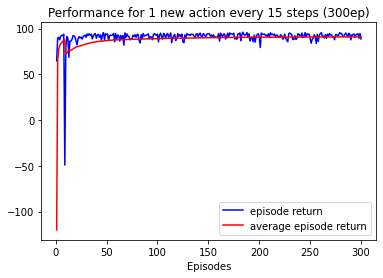

In [ ]:
import matplotlib
matplotlib.use('TkAgg') # it tackles UserWarning Issue
import matplotlib.pyplot as plt
%matplotlib inline

average_return_list =[-120]
avg = 0
for i in range(1,len(return_list)):
  avg = sum(return_list[:i])/len(return_list[:i])
  average_return_list.append(avg)

plt.plot(episode_list, return_list, label= "episode return", c='b')
plt.plot(episode_list, average_return_list , label= "average episode return", c='r')
plt.legend(loc = 'lower right')
plt.xlabel('Episodes')
plt.title('Performance for 1 new action every 15 steps (300ep)')
plt.show()